In [1]:
import sys
import os.path
# sys.path.append(
#     os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
# sys.path.append('../')
# import models.models as database
# from sqlalchemy.exc import IntegrityError
# from config.config import env
import pandas as pd
import numpy as np
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

def import_sp_stop_words(jsonfile):
    with open(jsonfile, 'r') as file:
        jsondict = json.load(file)
    return jsondict['stop_words_es']

SPANISH_STOP_WORDS = import_sp_stop_words('../local_data/stop_words_es.json')


/Users/pablojordan/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


/Users/pablojordan/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


############### NAIVE BAYES - TRAINING MODEL#########
TEST LABELS
[2 1 1 2 1 1 3 1 1 2 3 3 1 1 3 3 1]
PREDICTED LABELS
[2 1 1 1 1 2 3 1 1 2 3 3 1 1 3 3 1]
###############END TRAINING MODEL#########



['salut', 'hola, pero en frances', 'que se supone que eres?', 'y tu?', 'cuales son tus tareas?', 'y con quienes trabajas?', 'lo se', 'que musica escuchas?']
###############CHAT TEXT FEATURES #########

############### PREDICTION LABELS ON CHAT #########
[3 3 3 1 2 1 1 3]
{1: 3, 2: 1, 3: 4}
{'Normal': 0.375, 'Troll': 0.125, 'Pedófilo': 0.5}

PORCENTAJE DE PRUEBA:  5.0
EXACTITUD:  0.8823529411764706
POSIBLE PERFIL DE CONVERSACION: Pedófilo


############### NAIVE BAYES - TRAINING MODEL#########
TEST LABELS
[2 1 1 2 1 1 3 1 1 2 3 3 1 1 3 3 1 2 3 3 2 3 2 2 1 2 2 3 2 3 2 2 2]
PREDICTED LABELS
[2 1 1 1 1 2 3 1 1 2 3 3 1 1 3 3 1 2 3 3 2 3 1 2 2 1 2 3 2 1 2 2 1]
###############END TRAINING MODEL#########



['salut', 'hola, pero en frances', 'que se supone que eres?', 'y tu?', 'cuales son tus tar

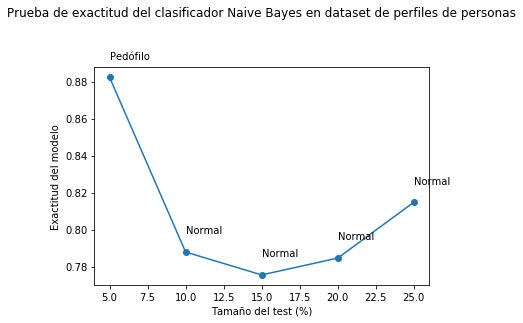

In [3]:
def getConversation(userid):
    endpoint = "http://localhost:3000/user/{0}/conversation/user-text".format(userid)
    response = requests.get(endpoint).json()
    json_data = response['conversation']
    word_data = [ word['message'] for word in json_data ]
    return word_data

def vectorizer(word_file, label_file):
    ## Get stop words list from JSON FILE
    global SPANISH_STOP_WORDS
    with open(label_file, 'r') as profiles:
        labels = [int(y.split(',')[1] ) for y in profiles]  
    ## FEATURES AS PARAGRAPHS OF TEXT
    with open(word_file, 'r') as words:
        word_data = [x[3:] for x in words]
#     X_train, X_test, y_train, y_test = train_test_split(word_data, labels, random_state=1, 
#                                                         test_size=0.1)
#     print('TEXT TEST FEATURES')
#     print( X_test)
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words=SPANISH_STOP_WORDS)
    features_train_transformed = vectorizer.fit_transform(word_data)
    features = vectorizer.get_feature_names()
    features_train_transformed = features_train_transformed.toarray()
#     return pd.DataFrame(dense_matrix, columns=features)
    return features_train_transformed, np.asarray(labels)

def vectorizeText(text, n_features):
    ## Get stop words list from JSON FILE
    NUM_FEATURES = n_features
    global SPANISH_STOP_WORDS
    vectorizer = TfidfVectorizer(sublinear_tf=True,
                                 stop_words=SPANISH_STOP_WORDS)
    features_train_transformed = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names()
    feature_transformed = features_train_transformed.toarray()
    n,m = feature_transformed.shape
#     return pd.DataFrame(dense_matrix, columns=features)
    z = np.array([])
    if m < NUM_FEATURES:
        z = np.zeros((n, NUM_FEATURES - m )) 
#     print(z.shape)
    return np.concatenate((feature_transformed, z ), axis = 1)

def NBClf(test_size=0.1):
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.cross_validation import train_test_split
    from sklearn import metrics
    
    features_transformed, labels = vectorizer('../local_data/text-profiles-test.csv'
                                              , '../local_data/labels-profiles-test.csv')
    X_train, X_test, y_train, y_test = train_test_split(features_transformed, labels, random_state=1, 
                                                        test_size=test_size)

    # 2. instantiate a Multinomial Naive Bayes model
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    n, m = X_test.shape
    print("############### NAIVE BAYES - TRAINING MODEL#########")
#     print('TEST FEATURES')
#     print(X_test)
    print('TEST LABELS')
    print(y_test)
    # print(X_test.shape)
    y_pred = nb.predict(X_test)
    print('PREDICTED LABELS')
    print(y_pred)
    
    # print(nb.classes_)
    # print(nb.class_count_)

    accuracy = metrics.accuracy_score(y_test, y_pred)
#     print('EXACTITUD DE CLASIFICACION')
#     print(accuracy)
    print("###############END TRAINING MODEL#########")
    print()
    print()
    print()
    
    return nb, m, accuracy

def classifyConversation(clf, userid):
    try:
        import operator
        c = getConversation(userid)
        print(c)
        TOTAL_CONVERSATIONS = len(c)
        print("###############CHAT TEXT FEATURES #########")
        # c = ['porque eres tan estudpido']
        test = vectorizeText(c, n_features)

        y_pred = clf.predict( test )
        print()
        print("############### PREDICTION LABELS ON CHAT #########")
        print(y_pred)
        unique, counts = np.unique(y_pred, return_counts=True)
        pred_profiles = dict(zip(unique, counts))
        profiles = [1, 2, 3]
        keys = pred_profiles.keys()
        for i in profiles:
            if i not in keys:
                pred_profiles[i] = 0
        
        print(pred_profiles)
        means = { 
                    'Normal': pred_profiles[1] / float(TOTAL_CONVERSATIONS),
                    'Troll': pred_profiles[2] / float(TOTAL_CONVERSATIONS),
                    'Pedófilo': pred_profiles[3] / float(TOTAL_CONVERSATIONS)
                }
        print(means)
        return max(means.items(), key=operator.itemgetter(1))[0]
    except Exception as e:
        print('there was an exception')
        print(e)
        
    
    
if __name__ == "__main__":    
    test_percents = np.arange(0.05, 0.30, 0.05)
    accuracies = []
    profiles_predicted = []
    for p in test_percents:
        clf, n_features, acc = NBClf(p)
#         print(clf, n_features, acc)
        accuracies.append(acc)
#         test = vectorizeText(clf, n_features)
#         y_pred = clf.predict( test )
        possible_profile = classifyConversation(clf, 21)
        profiles_predicted.append(possible_profile)
        print()
        print("PORCENTAJE DE PRUEBA: ", p * 100)
        print("EXACTITUD: ", acc)
        print("POSIBLE PERFIL DE CONVERSACION: {0}".format(possible_profile))
        print()
        print()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    test_percentage = test_percents * 100 
    ax.plot(test_percentage, accuracies, marker='o')
    plt.title('Prueba de exactitud del clasificador Naive Bayes en dataset de perfiles de personas\n\n\n')
    plt.xlabel('Tamaño del test (%)')
    plt.ylabel('Exactitud del modelo')
    for i, profile in enumerate(profiles_predicted):
        ax.annotate(profile,
                     xy=(test_percentage[i], accuracies[i] ),
                     xytext=(test_percentage[i], accuracies[i] + 0.01 )
                    )
    plt.show()